In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/COVID_19_XRAY


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/COVID_19_XRAY


In [2]:
import  numpy as np
import  pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import PIL
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Data 불러오기 / 전처리 / train, val, test 분리

In [3]:
label_df = pd.read_csv('labels.csv')
label_df['label'] = label_df['label'].replace({'normal': 0, 'covid': 1}) #label 변경
label_df

,filename,label
0,image_001.png,1
1,image_002.png,1
2,image_003.png,0
3,image_004.png,0
4,image_005.png,0
...,...,...
1995,image_1996.png,1
1996,image_1997.png,0
1997,image_1998.png,1
1998,image_1999.png,0


In [4]:
label_counts = label_df['label'].value_counts()
print(label_counts)

1    1000
0    1000
Name: label, dtype: int64


In [5]:
images = []
labels = []

png_files = glob.glob('train/*.png')

for i, png_file in enumerate(png_files):
   
    img = Image.open(png_file)
    # Resize the image to 299 x 299 pixels and normalize the pixel values to [0, 1]
    img = img.resize((299, 299))
    #img = img.resize((500, 500))
    img = np.array(img) / 255.0
    
    # Get the label for the current image
    filename = os.path.basename(png_file)
    idx = int(filename.split('_')[1].split('.')[0]) - 1
    label = label_df.iloc[idx]['label']
    
    # Append the image and label to their respective lists
    images.append(img)
    labels.append(label)

# Convert the images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [6]:
images = np.reshape(images, (-1, 299, 299, 1))
#images = np.reshape(images, (-1, 500, 500, 1))

x_train_val, x_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify = labels)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

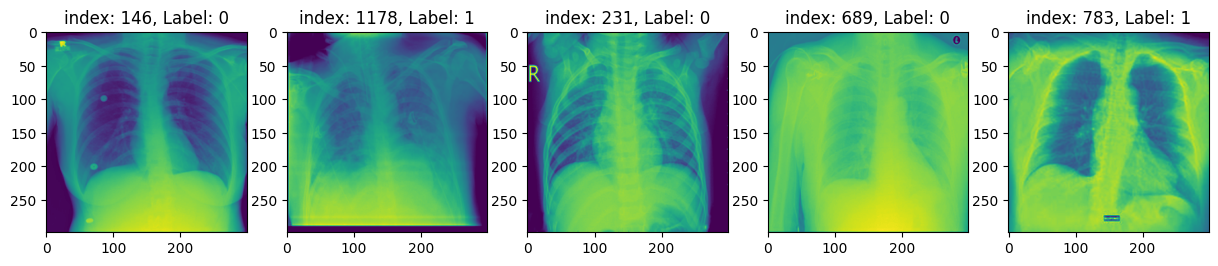

In [ ]:
num_sample = 5
random_idxs = np.random.randint(1200, size=num_sample)

plt.figure(figsize=(15,3))
for i, idx in enumerate(random_idxs):
  img = x_train[idx, :]
  label = y_train[idx]

  plt.subplot(1, len(random_idxs), i+1)
  plt.imshow(img)
  plt.title('index: {}, Label: {}'.format(idx, label))

# Model and Training.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 32)       0

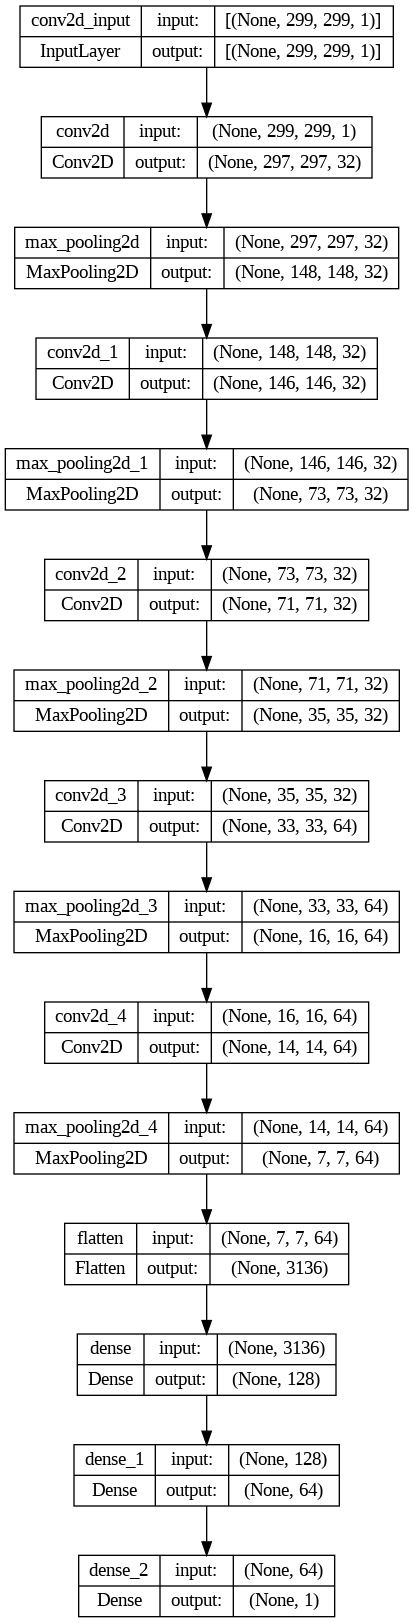

In [7]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(299,299,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(299,299,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(299,299,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_val, y_val))




Epoch 1/25
38/38 [==============================] - 19s 112ms/step - loss: 0.6931 - accuracy: 0.5375 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 2/25
38/38 [==============================] - 2s 60ms/step - loss: 0.5827 - accuracy: 0.6958 - val_loss: 0.4646 - val_accuracy: 0.7950
Epoch 3/25
38/38 [==============================] - 2s 58ms/step - loss: 0.4478 - accuracy: 0.8000 - val_loss: 0.3855 - val_accuracy: 0.8050
Epoch 4/25
38/38 [==============================] - 2s 61ms/step - loss: 0.4016 - accuracy: 0.8217 - val_loss: 0.3882 - val_accuracy: 0.8300
Epoch 5/25
38/38 [==============================] - 2s 62ms/step - loss: 0.3412 - accuracy: 0.8483 - val_loss: 0.2954 - val_accuracy: 0.8700
Epoch 6/25
38/38 [==============================] - 2s 64ms/step - loss: 0.2841 - accuracy: 0.8842 - val_loss: 0.2822 - val_accuracy: 0.8800
Epoch 7/25
38/38 [==============================] - 2s 66ms/step - loss: 0.2365 - accuracy: 0.8942 - val_loss: 0.3865 - val_accuracy: 0.8450
Epoch 8/25


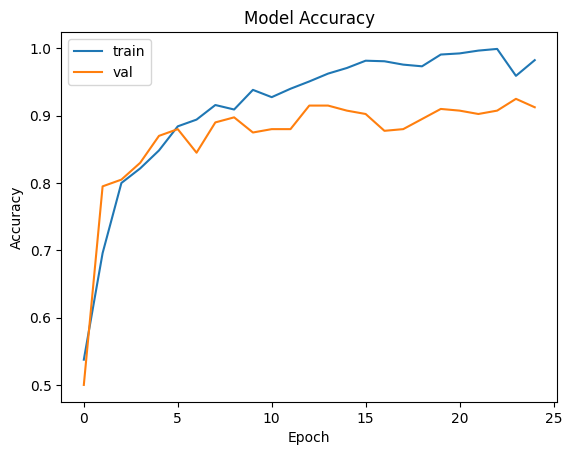

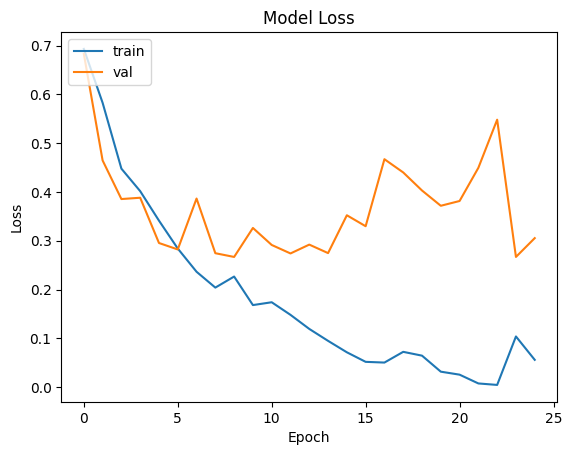

In [10]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

13/13 [==============================] - 0s 22ms/step - loss: 0.3183 - accuracy: 0.9125
Test accuracy: 0.9125000238418579


# submission.csv

In [11]:
t_images = []
# Load the test image filenames
test_filenames = os.listdir('test')
test_filenames = [filename for filename in test_filenames if filename.endswith('.png')]
test_filenames = sorted(test_filenames, key=lambda x: int(x.split('_')[1].split('.')[0]))
png_files = glob.glob('test/*.png')

for i, png_file in enumerate(png_files):
   
    img = Image.open(png_file)
    img = img.resize((299, 299))
    img = np.array(img) / 255.0
    
   
    filename = os.path.basename(png_file)
    idx = int(filename.split('_')[1].split('.')[0]) - 1

    t_images.append(img)

t_images = np.array(t_images)

predictions = model.predict(t_images)


predicted_labels = np.round(predictions).astype(int).reshape(-1)

submission_df = pd.DataFrame({'filename': test_filenames, 'label': predicted_labels})

submission_df.to_csv('submission.csv', index=False)

['test/image_001.png', 'test/image_002.png', 'test/image_003.png', 'test/image_004.png', 'test/image_005.png', 'test/image_006.png', 'test/image_007.png', 'test/image_008.png', 'test/image_009.png', 'test/image_010.png', 'test/image_011.png', 'test/image_012.png', 'test/image_013.png', 'test/image_014.png', 'test/image_015.png', 'test/image_016.png', 'test/image_017.png', 'test/image_018.png', 'test/image_019.png', 'test/image_020.png', 'test/image_021.png', 'test/image_022.png', 'test/image_023.png', 'test/image_024.png', 'test/image_025.png', 'test/image_026.png', 'test/image_027.png', 'test/image_028.png', 'test/image_029.png', 'test/image_030.png', 'test/image_031.png', 'test/image_032.png', 'test/image_033.png', 'test/image_034.png', 'test/image_035.png', 'test/image_036.png', 'test/image_037.png', 'test/image_038.png', 'test/image_039.png', 'test/image_040.png', 'test/image_041.png', 'test/image_042.png', 'test/image_043.png', 'test/image_044.png', 'test/image_045.png', 'test/ima

In [13]:
submission_df

,filename,label
0,image_001.png,1
1,image_002.png,1
2,image_003.png,0
3,image_004.png,1
4,image_005.png,0
...,...,...
395,image_396.png,0
396,image_397.png,0
397,image_398.png,0
398,image_399.png,0
